In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from mppi import Utilities as U, Parsers as P
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

In [3]:
def Bloch_Eq(u, t, delta, Omega_r):
    dudt = [delta*u[1], -delta*u[0]+Omega_r(t)*u[2],-Omega_r(t)*u[1]]
    return dudt

# TLS description of spin polarization in GaAs

In this notebook we use the TLS model to describe the time evolution of the spin polarization in GaAS.

Here we assume the a first optical pump has excited the electrons in the first two conduction bands
and we describe the dynamics in the conduction sector using the TLS. The interaction with a second
THz field is described entirely within this sector.

For the  general formula and properties of a TLS we refer to the notebook _TLS_optical_absorption_.

## TLS analysis for a single k point (before the fixsymm)

We use the TLS to reproduce the results written in

In [5]:
ref = P.YamboParser.from_path('SPIN_ECHO/RT_singlek_high-freq/FixSymm','SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_Glesser')

Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_Glesser/o-echo_THz_pi_Glesser.polarization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_Glesser/o-echo_THz_pi_Glesser.orbt_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_Glesser/o-echo_THz_pi_Glesser.carriers
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_Glesser/o-echo_THz_pi_Glesser.external_field
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_Glesser/o-echo_THz_pi_Glesser.spin_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_Glesser/o-echo_THz_pi_Glesser.current
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/SAVE/ns.db1
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_Glesser/ndb.dipoles
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_Glesser/ndb.RT_G_PAR


In [12]:
ref.get_info()

YamboOutputParser variables structure
suffix polarization with dict_keys(['time', 'Pol_x', 'Pol_y', 'Pol_z'])
suffix orbt_magnetization with dict_keys(['col0', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6'])
suffix carriers with dict_keys(['time', 'dnhmne', 'dnh', 'dne'])
suffix external_field with dict_keys(['time', 'Ex_Re', 'Ey_Re', 'Ez_Re', 'Ex_Im', 'Ey_Im', 'Ez_Im', 'Intensity', 'Fluence'])
suffix spin_magnetization with dict_keys(['time', 'Ms_x', 'Ms_y', 'Ms_z', 'Mv_x', 'Mv_y', 'Mv_z', 'Mc_x', 'Mc_y', 'Mc_z'])
suffix current with dict_keys(['col0', 'col1', 'col2', 'col3'])
 
YamboDipolesParser variables structure
dip_ir shape (48, 4, 4, 3, 2)
dip_v shape (48, 4, 4, 3, 2)
dip_spin shape (48, 4, 4, 3, 2)
 
YamboDftParser variables structure
number of k points 48
number of bands 12
spin degeneration 2
 
YamboRTGlesserParser variables structure
Gless shape (16003, 48, 4, 4, 2)


In [13]:
ref_time = 1e-3*ref.data['spin_magnetization']['time']
ref_pz = ref.data['spin_magnetization']['Mc_z']
ref_ex = ref.data['external_field']['Ex_Re']
ref_int = ref.data['external_field']['Intensity']

There are 48 kpoint all with the same transition energy

In [10]:
de_ccp = 1e3*ref.dft.get_transitions(initial=[8,9],final=[8,9])[0][0]
de_ccp # meV

0.9444647438892062

We select the first k point and set the intensity of the field to ha ve the $\pi$ condition on this point

In [11]:
k_ref = 0
dip = ref.dipoles.get_r_dipole(k_ref,2,3,0)
dip

array([15.27632319, 22.94874198])

We set the FWH of the THz pulse

In [14]:
fwhm =  20 #ps

In [30]:
pars = U.pulseParametersFromTheta(dip,np.pi,fwhm=fwhm,THz_pulse=True)
pars

time unit: ps
set width to 8.493218002880191 ps
coupling frequency (ps^-1): 0.14756646266356058
field amplitude (V/m): 66579.79073343563
field intensity (kW/cm^2) : 1.1766689276495998


(0.14756646266356058, 66579.79073343563, 1.1766689276495998)

In [31]:
intensity = pars[2]
intensity

1.1766689276495998

We build a pulse with the aim to reproduce exactly the one created by yambo Since we will start the TLS analysis
at $t_0=0.5$ ps (where the Bloch are init with the values read from yambo). We set the t_start of the pulse at $t_0$
and we shift the pulse time of the same quantity

In [16]:
N = int(1e4)
pulse_time = np.linspace(0,80,N) # in ps
t0 = 0.5

In [17]:
pulse = U.gaussianPulse(pulse_time,energy=de_ccp,amplitude=pars[1],fwhm=fwhm,THz_pulse=True,t_start=t0,envelope_only=False)

time unit: ps - energy unit: meV
period of the oscillations 4.378848150754763 ps
width of the pulse 8.493218002880191 ps
fwhm of the pulse 20 ps


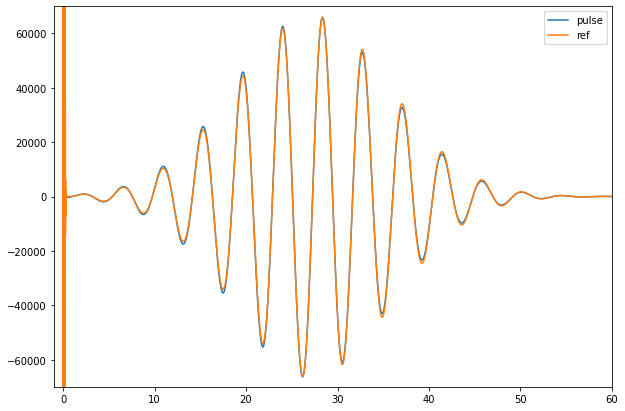

In [18]:
plt.figure(figsize=(10,7))
plt.plot(t0+pulse_time,pulse,label='pulse')
plt.plot(ref_time,ref_ex,label='ref')
plt.ylim(-70000,70000)
plt.xlim(-1,60)
plt.legend()

Now we solve the Bloch equations.

We use a reference calculation to extract the _initial time_ bloch vectors

In this simulation the index = 100 correspond to a time of 0.5 ps

In [19]:
tstep = 8e4/(16003-1)
tstep*100

499.9375078115236

In [22]:
ref_bloch = ref.RTGreen.buildBlochVectors(first_time=0,first_band=2)
ref_bloch.shape

(3, 16003, 48)

In [23]:
bloch0 = ref_bloch[:,100,:]
bloch0.shape

(3, 48)

In [24]:
nk = bloch0.shape[1]
nk

48

In [25]:
bloch = np.zeros([3,N,nk])
bloch.shape

(3, 10000, 48)

In [26]:
delta_psm1 = 0.

In [27]:
couplings = []

In [32]:
for k in range(nk):
    dip_k = ref.dipoles.get_r_dipole(k,2,3,0)
    pars = U.pulseParametersFromIntensity(dip_k,intensity,fwhm=fwhm,THz_pulse=True,verbose=False)
    couplings.append(pars[0])
    Omega_r = lambda t: U.gaussianPulse(t,energy=de_ccp,amplitude=pars[0],fwhm=fwhm,THz_pulse=True,
                t_start=t0,envelope_only=True,verbose=False)
    sol = odeint(Bloch_Eq, bloch0[:,k], pulse_time, args=(delta_psm1, Omega_r))
    bloch[:,:,k] = sol.T

coupling 0.14756646266356058


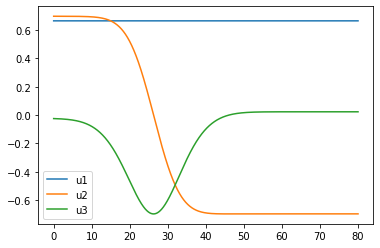

In [33]:
k = 0
print('coupling',couplings[k])
plt.plot(pulse_time,bloch[0,:,k],label='u1')
plt.plot(pulse_time,bloch[1,:,k],label='u2')
plt.plot(pulse_time,bloch[2,:,k],label='u3')
plt.legend(loc='best')

In [34]:
bloch[:,0,k],bloch[:,-1,k]

(array([ 0.66401124,  0.69640949, -0.02491248]),
 array([ 0.66401124, -0.69647804,  0.02291885]))

We rotate the Bloch vector in the original frame

In [35]:
omega = de_ccp/(U.Planck_reduced_ev_ps*1e3)

In [36]:
bloch_of = np.zeros([3,N,nk])
for k in range(nk):
    bloch_of[0,:,k] = np.cos(omega*pulse_time)*bloch[0,:,k] - np.sin(omega*pulse_time)*bloch[1,:,k]
    bloch_of[1,:,k] = np.sin(omega*pulse_time)*bloch[0,:,k] + np.cos(omega*pulse_time)*bloch[1,:,k]
    bloch_of[2,:,k] = bloch[2,:,k]

We can plot the Bloch vectors and compare the model with the rt simulation

coupling 0.14756646266356058


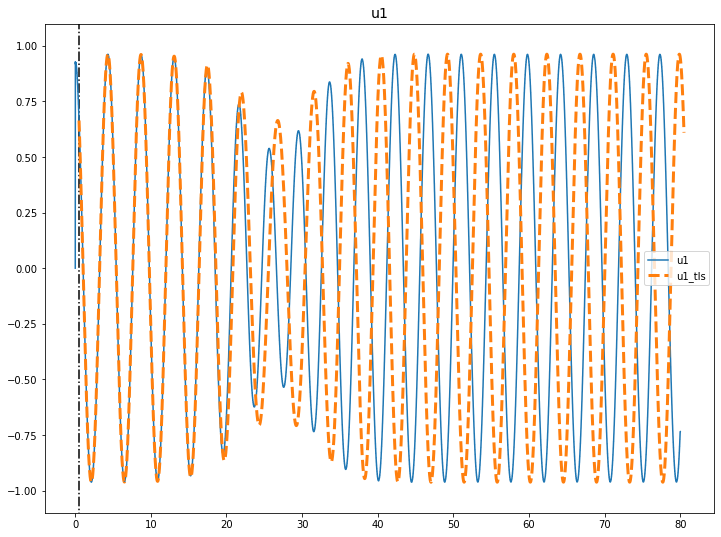

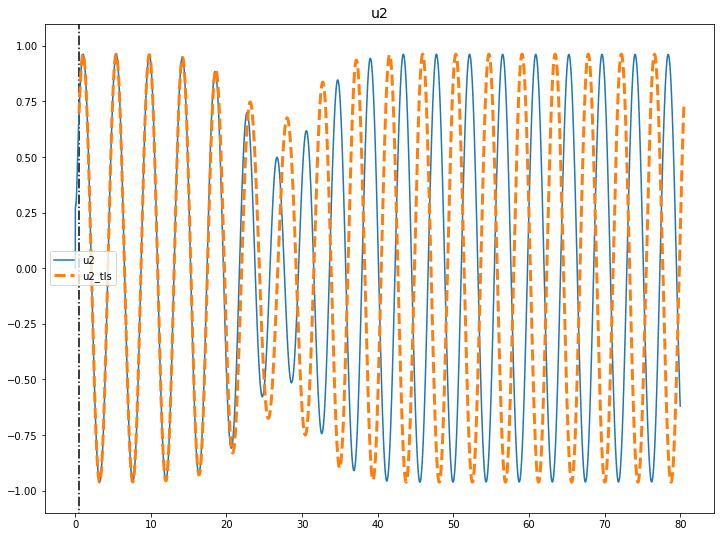

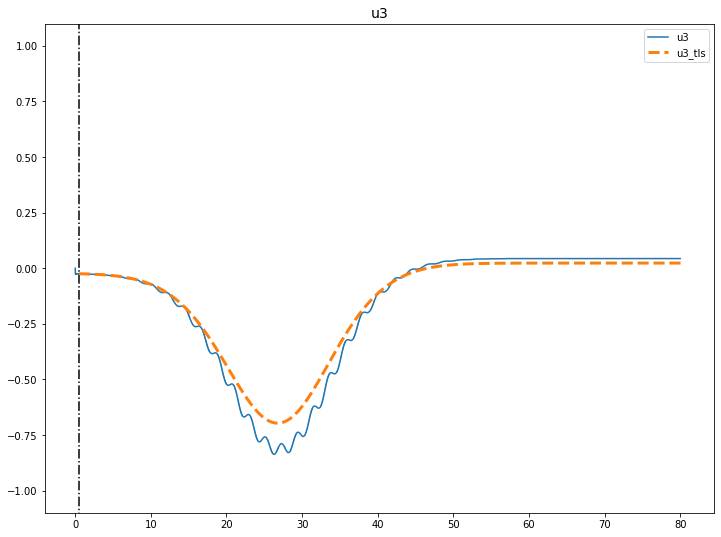

In [39]:
k = 0
print('coupling',couplings[k])

rt = 1e-3*np.array([tstep*ind for ind in range(len(ref_bloch[0]))])

fig, ax = plt.subplots(figsize=(12, 9))
plt.plot(rt,ref_bloch[0,:,k],label='u1')
plt.plot(t0+pulse_time,bloch_of[0,:,k],label='u1_tls',linestyle='--',linewidth=3)
plt.legend()
plt.title('u1',size=14)
plt.vlines(t0,-2,2,color='black',linestyles='-.')
plt.ylim(-1.1,1.1)
plt.show()

fig, ax = plt.subplots(figsize=(12, 9))
plt.plot(rt,ref_bloch[1,:,k],label='u2')
plt.plot(t0+pulse_time,bloch_of[1,:,k],label='u2_tls',linestyle='--',linewidth=3)
plt.legend()
plt.title('u2',size=14)
plt.vlines(t0,-2,2,color='black',linestyles='-.')
plt.ylim(-1.1,1.1)
plt.show()

fig, ax = plt.subplots(figsize=(12, 9))
plt.plot(rt,ref_bloch[2,:,k],label='u3')
plt.plot(t0+pulse_time,bloch_of[2,:,k],label='u3_tls',linestyle='--',linewidth=3)
plt.legend()
plt.title('u3',size=14)
plt.vlines(t0,-2,2,color='black',linestyles='-.')
plt.ylim(-1.1,1.1)
plt.show()

Once that we have the Bloch vector we can compute the expectation value of the spin polarization

In [42]:
dip_spin = ref.dipoles.dip_spin
Sz = dip_spin[:,2:,2:,2,0] + 1j*dip_spin[:,2:,2:,2,1]
Sz.shape

(48, 2, 2)

In [43]:
pz_k = np.zeros([N,nk])
for k in range(nk):
    A = Sz[k,0,0].real
    B = Sz[k,0,1].real
    C = Sz[k,0,1].imag
    pz_k[:,k] = (A*bloch_of[2,:,k]+B*bloch_of[0,:,k]+C*bloch_of[1,:,k]) 

In [44]:
pz_avg = np.zeros([N])
for t in range(N):
    pz_avg[t] = np.average(pz_k[t,:].real)

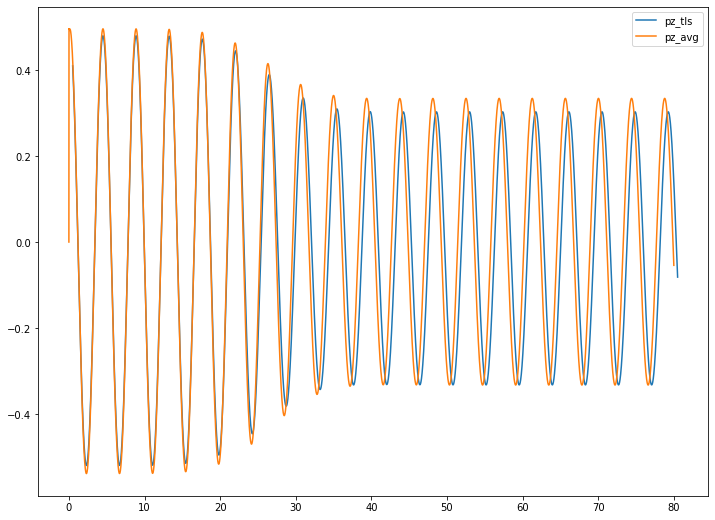

In [45]:
plt.figure(figsize=(12,9))
plt.plot(t0+pulse_time,pz_avg,label='pz_tls')
plt.plot(ref_time,ref_pz,label='pz_avg')
plt.legend()

In [ ]:
###############################################################################

## Spin polarization after the pump

We seek for a initial configuration of the density matrix that produce the expected spin polarization.

Here we assume that if the spin of the conduction bands point in the $z$ direction then the shape of the DM
that gives expected degree of spin polarization ($p_z=1/2$ since we are very close to $\Gamma$) is
$$
\rho = 3/4|+\rangle\langle+|+1/4|-\rangle\langle-|
$$
However the spin of the conduction bands points in $k$ dependent $\mathbf{n}$ directions so we need to express the DM 
in the new basis. 

The eigenstates of $\mathbf{S}\cdot\mathbf{n}$ are
$$
|1\rangle = \left(\begin{array}{c}
cos(\theta/2)\\
sin(\theta/2)e^{i\phi}\\
\end{array} \right) \, , \quad
|2\rangle = \left(\begin{array}{c}
sin(\theta/2)\\
-cos(\theta/2)e^{i\phi}\\
\end{array} \right)
$$
where $\theta$ and $\phi$ are the angles that define the $\mathbf{n}$ versor in spherical
coordinates.

The expectation values of the cartesian components of $\mathbf{S}$ on the $|1\rangle$ state
reads (here $S_i$ are just the Pauli matrix without the $1/2$ factor)
$$
\langle1|S_x|1\rangle = sin(\theta)cos(\phi) \, , \quad
\langle1|S_y|1\rangle = sin(\theta)sin(\phi) \, , \quad
\langle1|S_z|1\rangle = cos(\theta) 
$$
these relations can be used to determine the values of $\theta$ and $\phi$ from the expectation
values of the spin on one bands (that is elected as $|1\rangle$ of the new basis).

The inverse relation between the two basis reads
$$
|+\rangle = cos(\theta/2)|1\rangle + sin(\theta/2)|2\rangle \\
|-\rangle = sin(\theta/2)e^{-i\phi}|1\rangle - cos(\theta/2)e^{-i\phi}|2\rangle
$$
so that
$$
|+\rangle\langle+| = cos(\theta/2)^2|1\rangle\langle1|+sin(\theta/2)^2|2\rangle\langle2|+
1/2sin(\theta)(|1\rangle\langle2|+|2\rangle\langle1|) \\
|-\rangle\langle-| = sin(\theta/2)^2|1\rangle\langle1|+cos(\theta/2)^2|2\rangle\langle2|-
1/2sin(\theta)(|1\rangle\langle2|+|2\rangle\langle1|)
$$
To conclude this analysis we have to express the matrix elements of $S_z$ in the basis 1,2. 
Then we can check that the expected degree of spin polarization is achieved and we can use
the DM as initial condition in the EQM of the TLS.
$$
\langle 1|S_z|1\rangle = cos(\theta) \, , \quad \langle 2|S_z|2\rangle = -cos(\theta) \, \quad
\langle 1|S_z|2\rangle = sin(\theta)
$$
So
$$
\rho = \left(\begin{array}{cc}
3/4cos(\theta/2)^2+1/4sin(\theta/2)^2 & 1/4sin(\theta)\\
1/4sin(\theta) & 3/4sin(\theta/2)^2+1/4cos(\theta/2)^2\\
\end{array} \right) \\
S_z = \left(\begin{array}{cc}
cos(\theta) & sin(\theta)\\
sin(\theta) & -cos(\theta)\\
\end{array} \right)
$$
and the trace gives
$$
Tr(\rho S_z) = 1/2
$$
as expected. From this from of the DM we can read the values of the Bloch vector after the pump
$$
u_3 = \rho_{11}-\rho_{22} = 3/4cos(\theta)-1/4sin(\theta) \, , \quad
u_1 = 1/2sin(\theta) \, , \quad
u_2 = 0
$$

For arbitrary form of the DM spin polarization $p_z$ is expressed as
$$
p_z = \rho_{11}S^z_{11}+\rho_{22}S^z_{22}+\rho_{12}S^z_{21}
+\rho_{21}S^z_{12} = \\
 = cos(\theta)(\rho_{11}-\rho_{22}) +2sin(\theta)Re(\rho_{12}) = \\
= cos(\theta)u_3 + sin(\theta)u_1
$$
Now we have all the elements to compute the time evolution of $p_z$ using the TLS model.

In [3]:
#dipoles = P.YamboDipolesParser('SPIN_ECHO/RT_gamma/FixSymm/gamma/ndb.dipoles')
dipoles = P.YamboDipolesParser('SPIN_ECHO/RT_singlek_high-freq/FixSymm/singlek_high-freq/ndb.dipoles')
dipoles.get_info()
spin = dipoles.dip_spin

Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/singlek_high-freq/ndb.dipoles
YamboDipolesParser variables structure
dip_ir shape (48, 4, 4, 3, 2)
dip_v shape (48, 4, 4, 3, 2)
dip_spin shape (48, 4, 4, 3, 2)


In [54]:
c1 = 2
c2 = 3
s11 = spin[0][c1][c1] 
s22 = spin[0][c2][c2] 
s12 = spin[0][c1][c2]
s21 = spin[0][c2][c1]

In [55]:
# clarify the meaning of this values. s_i is the Pauli matrix or the spin?
s11,s22,s12

(array([[ 0.68482554,  0.        ],
        [-0.02317222,  0.        ],
        [ 0.72560605,  0.        ]]),
 array([[-0.68494146,  0.        ],
        [ 0.02317717,  0.        ],
        [-0.72572895,  0.        ]]),
 array([[-0.72465445, -0.01365421],
        [-0.04147356,  0.99695318],
        [ 0.68260738,  0.04471952]]))

In [56]:
s1 = s11[:,0]
s2 = s22[:,0]
s1,s2

(array([ 0.68482554, -0.02317222,  0.72560605]),
 array([-0.68494146,  0.02317717, -0.72572895]))

In [57]:
np.linalg.norm(s1) # check the meaning of the norm

0.9980115818342685

In [58]:
theta = np.arccos(s1[2])
phi = np.arctan2(s1[1],s1[0])
theta,phi

(0.7588815951580713, -0.033823776384668595)

## Time evolution

In [59]:
def Bloch_Eq(u, t, delta, Omega_r):
    dudt = [delta*u[1], -delta*u[0]+Omega_r(t)*u[2],-Omega_r(t)*u[1]]
    return dudt

In [60]:
T = 100 # ps - lenght of the simulation
dt = 0.1 # ps - resolution of time sampling
N = int(T/dt) # number of sampled points
time = np.linspace(0,T,N+1)

In [61]:
dft = P.YamboDftParser('SPIN_ECHO/RT_singlek_high-freq/FixSymm/SAVE/ns.db1')
dft.get_info()

Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/SAVE/ns.db1
YamboDftParser variables structure
number of k points 48
number of bands 12
spin degeneration 2


There are 48 kpoints in this case. The ccp transition energies for all these points is

In [62]:
c1 = 8
c2 = 9
de_ccp = 1e3*dft.get_transitions(initial=[c1,c2],final=[c1,c2])[0][0]
de_ccp # meV

0.9444647438892062

In [63]:
fwhm =  20 #ps

In [65]:
c1 = 2
c2 = 3
dip = dipoles.get_r_dipole(0,c1,c2,0)
dip

array([15.27632319, 22.94874198])

In [67]:
# add the option THz_pulse to this method!
pars = U.pulsePararametersFromTheta(dip,np.pi,fwhm=fwhm*1e3)
pars

set width to 8493.21800288019 fs
coupling frequency (fs^-1): 0.0001475664626635606
field intensity (kW/cm^2) : 1.1766689269483663


(0.0001475664626635606, 1.1766689269483663)

In [112]:
coupl_freq = pars[0]*1e3 # ps^-1
coupl_freq

0.1475664626635606

In [113]:
pulse = U.gaussianPulse(time,energy=de_ccp,amplitude=coupl_freq,fwhm=fwhm,THz_pulse=True,t_start=1)

time unit: ps - energy unit: meV
period of the oscillations 4.378848150754763 ps^-1
width of the pulse 8.493218002880191 ps
fwhm of the pulse 20 ps


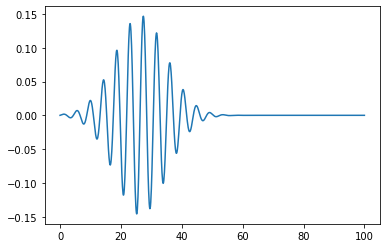

In [114]:
plt.plot(time,pulse)

In [115]:
u0 = [0.5*np.sin(theta),0.,3./4.*np.cos(theta)-1./4.*np.sin(theta)] # initial condition for the system after the pump
u0

[0.34405517715699163, 0.0, 0.37217694917436966]

In [117]:
# move in the rotating frame, so only the envelope of the pulse is considered
Omega_r = lambda t: U.gaussianPulse(t,energy=de_ccp,amplitude=coupl_freq,fwhm=fwhm,
                    THz_pulse=True,t_start=1,envelope_only=True,verbose=False)

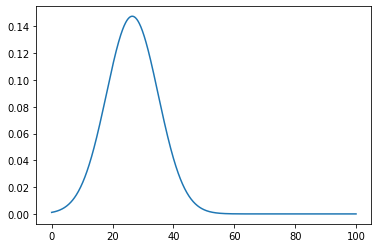

In [118]:
plt.plot(time,Omega_r(time))

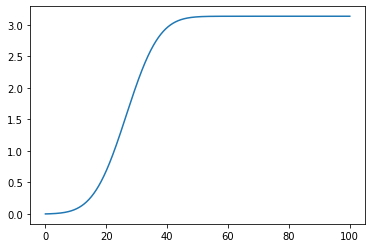

In [126]:
Theta = np.zeros([len(time)])
for ind in range(len(time)):
    Theta[ind] = np.trapz(Omega_r(time[:ind]),time[:ind])
plt.plot(time,Theta)

In [128]:
u2 = u0[1]*np.cos(Theta)+u0[2]*np.sin(Theta)
u3 = -u0[1]*np.sin(Theta)+u0[2]*np.cos(Theta)

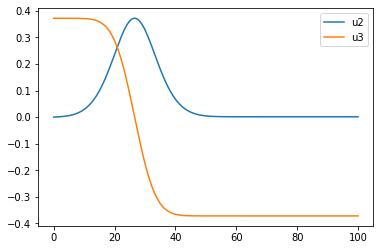

In [130]:
plt.plot(time,u2,label='u2')
plt.plot(time,u3,label='u3')
plt.legend()

In [131]:
delta_psm1 = 0. #choose the energy of the THz pump resonant with the ccp gap

In [132]:
sol = odeint(Bloch_Eq, u0, time, args=(delta_psm1, Omega_r))

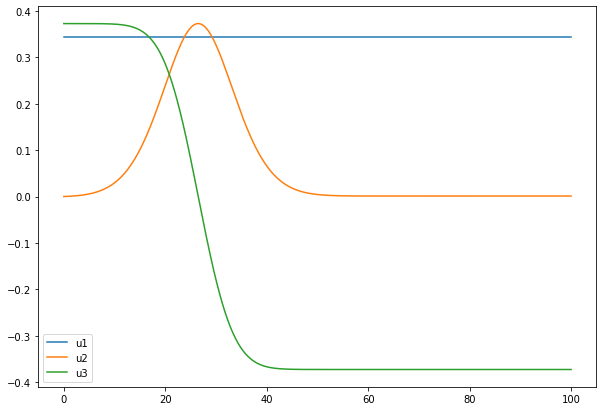

In [133]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(time,sol[:,0],label='u1')
plt.plot(time,sol[:,1],label='u2')
plt.plot(time,sol[:,2],label='u3')
plt.legend(loc='best')

We can reformulate the $u_1$ and $u_2$ components in the original frame

In [134]:
e_pump = de_ccp #meV
omega = e_pump/(U.Planck_reduced_ev_ps*1e3)

In [135]:
u1_of = np.cos(omega*time)*sol[:,0] - np.sin(omega*time)*sol[:,1]
u2_of = np.sin(omega*time)*sol[:,0] + np.cos(omega*time)*sol[:,1]

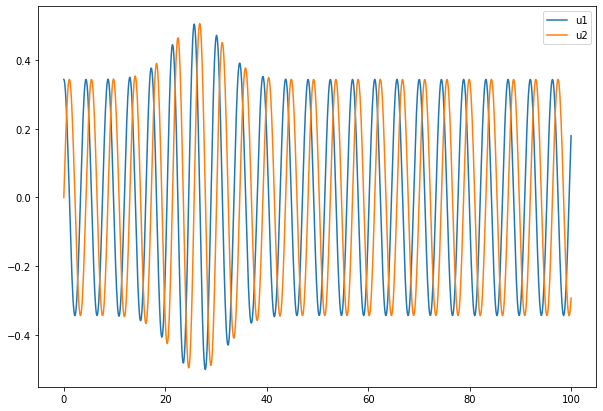

In [136]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(time,u1_of,label='u1')
plt.plot(time,u2_of,label='u2')
plt.legend(loc='best')

In [137]:
pz = sol[:,2]*np.cos(theta)+u1_of*np.sin(theta)

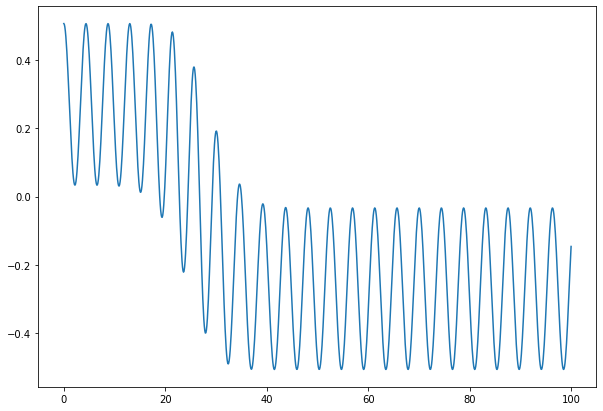

In [138]:
plt.figure(figsize=(10,7))
plt.plot(time,pz)

In [ ]:
##################################################################

We look for the rotation that convert s1 to (0,0,1) and s2 to (0,0,-1)

In [58]:
from scipy.spatial.transform import Rotation as R

In [59]:
#s1 = np.array([1./np.sqrt(2),0,1./np.sqrt(2)])
#s1 = np.array([1./np.sqrt(3),1./np.sqrt(3),1./np.sqrt(3)])
#s1,np.linalg.norm(s1)

In [60]:
theta_z = -np.arctan2(s1[1],s1[0])
Rz = R.from_rotvec(theta_z*np.array([0,0,1]))
s1t = Rz.apply(s1) #has zero y component
print(s1t)
theta_y = -np.arctan2(s1t[0],s1t[2])
Ry = R.from_rotvec(theta_y*np.array([0,1,0]))
Rtot = Ry*Rz

[ 6.17075841e-01 -5.55111512e-17  7.86903673e-01]


In [61]:
Rtot.apply(s1)

array([-5.55111512e-17, -2.18409644e-17,  9.99999992e-01])

In [62]:
Rtot.apply(s2)

array([ 7.29874161e-10,  3.49185066e-09, -9.99999989e-01])

In [63]:
Rtot.apply(s12[:,0])

array([ 8.42794106e-01, -5.38236071e-01, -2.44932241e-10])

In this basis the original $z$ axis has components (check if it is correct!)

In [51]:
znew = Rtot.apply(np.array([0,0,1]))
znew

array([-0.81649658,  0.        ,  0.57735027])

znew is unit vector $(n_x,n_y,n_z)$ with polar coordinates $\theta=arcos(n_z)$ and
$\phi=atan(n_y/n_x)$

In [52]:
theta = np.arccos(znew[2])
phi = np.arctan2(znew[1],znew[0])
theta,phi

(0.9553166181245092, 3.141592653589793)

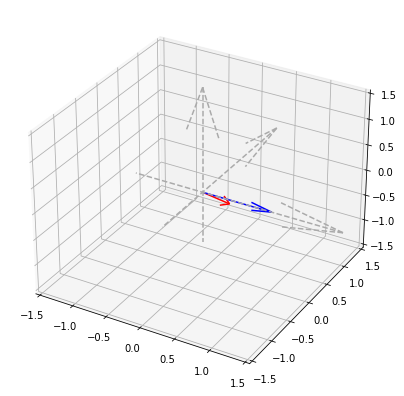

In [12]:
 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
# Cartesian axes
ax.quiver(-1, 0, 0, 3, 0, 0, color='#aaaaaa',linestyle='dashed')
ax.quiver(0, -1, 0, 0,3, 0, color='#aaaaaa',linestyle='dashed')
ax.quiver(0, 0, -1, 0, 0, 3, color='#aaaaaa',linestyle='dashed')
# Vector before rotation
ax.quiver(0, 0, 0, 1, 0, 0, color='b')
# Vector after rotation
ax.quiver(0, 0, 0, 0, 0.71, -0.71, color='r')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-1.5, 1.5])
plt.show()